Plan

- Make a pipeline to get the data in to a sql database
- Subset to just the bills introduced in the senate
    - Actions up to the first third reading
- Create the following features
    - Madigan or not
    - chief sponsor
    - number of co sponsors
    - committee it was in
    - perhaps how long something took (intro to second reading)
    - first word in description
    - 

# Put Data In DB

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from fuzzywuzzy import fuzz
from sklearn.preprocessing import StandardScaler
import re
from bs4 import BeautifulSoup
import requests
import time
import matplotlib.pyplot as plt
import requests
import pickle
import psycopg2 as pg
from sqlalchemy import create_engine

pd.set_option('display.max_rows', 235)

In [2]:
bills = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills.csv')

In [3]:
bills = bills.rename(columns={ 'bill_id': 'session_id', 'session_id': 'bill_number', 'bill_number': 'bill_id' })

In [4]:
bills.to_csv('./data/IL/2017-2018_100th_General_Assembly/csv/bills_renamed.csv')

In [3]:
local_engine = create_engine('postgresql://localhost:5432/ill_leg', echo=False)
# local

In [4]:
# connection_args = {
#     'host': '13.58.254.0', # You'll have to update this to your IP
#     'user': 'ubuntu',    # username
#     'dbname': 'ubuntu',   # DB that we are connecting to
#     'port': 5432         # port we opened on AWS
# }

# engine = pg.connect(**connection_args)

aws_engine = create_engine('postgresql://ubuntu@18.188.253.160:5432/ubuntu', echo=False)
# aws

In [ ]:
# bills.to_sql('bill', con=engine)

In [ ]:
history = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/history.csv').to_sql('history', con=engine)
# people = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/people.csv')
# roll_calls = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/rollcalls.csv')
# sponsors = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/sponsors.csv')
# votes = pd.read_csv('./data/IL/2017-2018_100th_General_Assembly/csv/votes.csv')

In [ ]:
# for name, df in zip(['history', 'people', 'roll_call', 'sponsor', 'vote'],[history, people, roll_calls, sponsors, votes]):
#     df.to_sql(name, con=engine)

# Fetch Data

In [ ]:
# Limit to just bills from this year that started in the Senate and got to a second reading
query_bills = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    )
    select * from bill
    where bill_id in (
        select * from started_senate
    ) and bill_id in (
        select * from had_sec_read
    );
"""

bills = pd.read_sql(query_bills, con=engine)

In [ ]:
bills = bills.drop(columns=['index'])

# Remove Trivial Resolutions

In [ ]:
bills = bills[~bills.last_action.str.contains('Resolution Adopted')]

In [ ]:
bills.status_desc.value_counts()

In [ ]:
526 / (526 + 1194)
# Passing percentage of non-resolution bills that get a second reading

# Explore Failures

In [ ]:
bills[bills.status_desc == 'Failed'].last_action.value_counts()
# evertything dies or is vetoed by gov (for the most part)
# only 8 things lost a senate vote (and one of those passed)
# vetoed is also a status (seems inconsistent - perhaps vetoed mean line item veto'd?)
# most of the hanging "introduced" bills had failed votes (4 introduced, 2 engrossed)

In [ ]:
bills.status_desc.value_counts()

In [381]:
def clean_bills(df):
    df = df[~df.last_action.str.contains('Resolution Adopted')].drop_duplicates(subset=['bill_id'])
    df.third_reading = df.third_reading.map(lambda x: 1 if x else 0)
    df.sponsor_count = df.sponsor_count.fillna(0)
    return df

# Get Ideology Data

In [13]:
ideology = pd.read_stata('./data/shor+mccarty+1993-2016+individual+legislator+data+May+2018+release+(Updated+July+2018).dta')

In [17]:
sen_ideol = ideology[[
    'name',
    'party',
    'st',
    'st_id',
    'np_score',
    'senate2015',
    'senate2016',
    'sdistrict2015',
    'sdistrict2016'
]]

In [22]:
ill_sen_ideol = sen_ideol[sen_ideol.st == 'IL'].dropna(subset=['senate2015', 'senate2016', 'sdistrict2015', 'sdistrict2016'], how='all')

In [37]:
ill_sen_ideol = ill_sen_ideol.replace(to_replace='', value=np.nan)

In [40]:
query_senators = """
    select * from people p
    where role = 'Sen'
"""

people = pd.read_sql(query_senators, con=engine)

In [55]:
ill_sen_ideol['first_last'] = ill_sen_ideol.name.map(lambda x: x.split(', ')[1] + ' ' + x.split(', ')[0])

In [108]:
def find_best_sen_match(first_last):
    sim_scores = people.name.map(lambda x: fuzz.token_set_ratio(x, first_last))
    if sim_scores.max() < 80:
        return np.nan
    return people.loc[sim_scores.idxmax(), 'people_id']

In [109]:
ill_sen_ideol['people_id'] = ill_sen_ideol.first_last.map(find_best_sen_match)

In [118]:
ill_sen_ideol.people_id = ill_sen_ideol.people_id.astype('Int32')

In [119]:
ill_sen_ideol.loc[ill_sen_ideol.first_last == 'Patricia Van Pelt', 'people_id'] = 14324
ill_sen_ideol.loc[ill_sen_ideol.first_last == 'William Jr. Brady', 'people_id'] = 1052

In [ ]:
# ill_sen_ideol.to_sql('ideology', con=engine)

# Number of Co-sponsors at Second Reading

In [382]:
query_sponsors_at_second = """
    with started_senate as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.sequence = 1 and h.chamber = 'Senate'
    ), had_sec_read as (
        select b.bill_id from bill b
        join history h on h.bill_id = b.bill_id
        where h.action like 'Second Reading'
    ), num_sponsors_at_sec as (
    	select b.bill_id, count(h.action) as sponsor_count
    	from bill b
    	join history hs on hs.bill_id = b.bill_id and hs.action ~* '^second reading'
    	join history h on h.bill_id = b.bill_id
    	where h.action ~* 'sponsor' and h.action ~* 'added' and h.sequence < hs.sequence
    	group by b.bill_id
    )
    select b.*, n.sponsor_count, case when h.index > 0 then true else false end as third_reading from bill b
    left join num_sponsors_at_sec n on n.bill_id = b.bill_id
    left join history h on h.bill_id = b.bill_id and h.action ~* 'third reading' and (h.action ~* 'passed' or h.action ~* 'lost')
    where b.bill_id in (
        select * from started_senate
    ) and b.bill_id in (
        select * from had_sec_read
    );
"""

bill_spons_sec = pd.read_sql(query_sponsors_at_second, con=engine)

In [383]:
bill_spons_sec = clean_bills(bill_spons_sec)

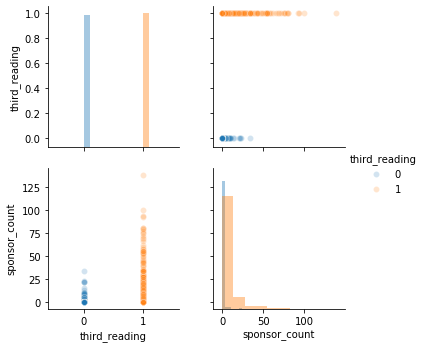

In [535]:
sns.pairplot(
    bill_spons_sec[['third_reading', 'sponsor_count']],
    plot_kws={ 'alpha': 0.2},
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

In [168]:
bill_spons_sec[bill_spons_sec.sponsor_count == 0].third_reading_id.value_counts()

0    793
1    328
Name: third_reading_id, dtype: int64

In [169]:
bill_spons_sec.sponsor_count.sum()

6538.0

# Ideology of Author

In [147]:
query_bill_author = """
    select b.bill_id, a.people_id, i.*, b.third_reading
    from sen_bill b
    left join author a on a.bill_id = b.bill_id
    left join ideology i on a.people_id = i.people_id
"""

author = pd.read_sql(query_bill_author, con=engine)
# 47 second query -> improve

In [164]:
std = StandardScaler()
author['scaled_np_score'] = np.abs(author.np_score - author.np_score.mean())

In [165]:
author.scaled_np_score.describe()

count    1468.000000
mean        0.520628
std         0.262165
min         0.006412
25%         0.458412
50%         0.491412
75%         0.695588
max         1.241588
Name: scaled_np_score, dtype: float64

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


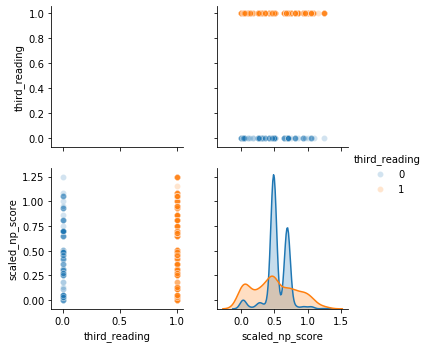

In [533]:
sns.pairplot(author[['third_reading', 'scaled_np_score']], plot_kws={ 'alpha': 0.2}, hue='third_reading')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([178.,  44., 123., 568.,  14., 331.,  84.,  58.,  55.,  13.]),
 array([0.00641213, 0.1299297 , 0.25344728, 0.37696485, 0.50048243,
        0.624     , 0.74751757, 0.87103515, 0.99455272, 1.1180703 ,
        1.24158787]),
 <a list of 10 Patch objects>)

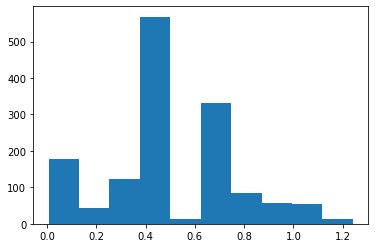

In [386]:
plt.hist(author['scaled_np_score'])

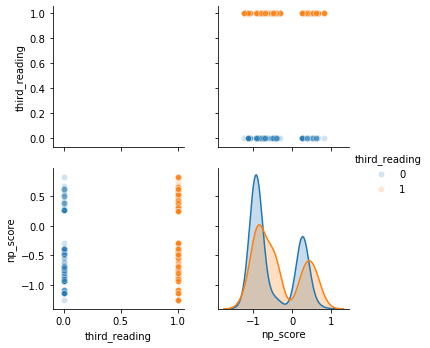

In [387]:
sns.pairplot(author[['third_reading', 'np_score']], plot_kws={ 'alpha': 0.2}, hue='third_reading')

# Ideology Range of Sponsors at 2nd Reading

In [173]:
query_range = """
select b.bill_id, min(i.np_score) as min_score, max(i.np_score) as max_score, b.third_reading
from sen_bill b
left join sponsor_at_second s on b.bill_id = s.bill_id
left join ideology i on i.people_id = s.people_id
group by b.bill_id, b.third_reading
"""

ideol_range = pd.read_sql(query_range, con=engine)

In [174]:
ideol_range['ideol_range'] = np.abs(ideol_range.max_score - ideol_range.min_score)
ideol_range.ideol_range = ideol_range.ideol_range.fillna(0)

In [175]:
ideol_range.head()

,bill_id,min_score,max_score,third_reading,ideol_range
0,1087131,NaN,NaN,1,0.000
1,1087344,NaN,NaN,0,0.000
2,1074782,0.431,0.655,1,0.224
3,1089962,-1.241,-0.436,0,0.805
4,1084143,NaN,NaN,1,0.000


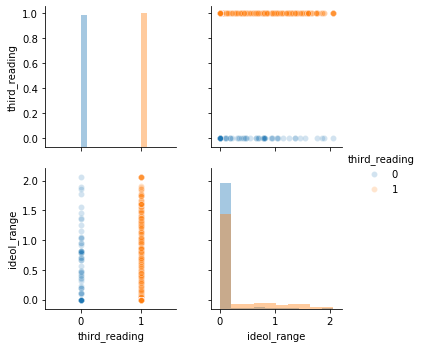

In [531]:
sns.pairplot(
    ideol_range[['third_reading', 'ideol_range']],
    plot_kws={ 'alpha': 0.2},
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)       


# Get Hearing Data

In [362]:
def scrape_slips(url):
    dfs = pd.read_html(url, attrs={ 'width': '100%', 'cellpadding': '3'}, header=0)
    hearing = dfs[0]
    if len(hearing) == 1:
        return pd.DataFrame(columns=['name', 'firm_business_or_agency', 'representing'])
    hearing['date'] = hearing.Name.map(lambda x: x if 'Hearing Date and Time' in x else np.nan)
    hearing.date = hearing.date.fillna(method='ffill')
    hearing = hearing.loc[~hearing.Name.str.contains('Hearing Date and Time')]
    hearing['bill_number'] = 'SB-0003'
    hearing.date = hearing.date.map(lambda x: pd.to_datetime(re.compile('\d{1,2}\/\d{1,2}\/\d{4}').search(x)[0]))
    hearing.columns = [x.lower().replace(' ', '_').replace(',', '') for x in hearing.columns]
    return hearing

In [363]:
def scrape_all_positions(url):
    frames = []
    for pos in ['PROP', 'OPP', 'NOPOS']:
        df = scrape_slips(url + '&WSType=' + pos)
        df['position'] = pos
        frames.append(df)
    return pd.concat(frames)

In [364]:
def scrape_totals(url):
    dfs = pd.read_html(url, attrs={ 'width': '600', 'bordercolor': 'white'})
    hearing_totals = dfs[0]
    col_names = ['proponents', 'opponents', 'no_position']
    hearing_totals.columns = col_names + ['na']
    hearing_totals = hearing_totals.dropna(how='all')[col_names]
    for col in ['proponents', 'opponents', 'no_position']:
        hearing_totals[col] = hearing_totals[col].map(lambda x: x.split(': ')[1]).astype('int')
    return hearing_totals

In [365]:
def scrape_100():
    all_sen_bills_url = 'http://www.ilga.gov/legislation/grplist.asp?num1=1&num2=3649&DocTypeID=SB&GA=100&SessionId=91'
    res = requests.get(all_sen_bills_url)
    bs = BeautifulSoup(res.text)
    hearing_frames = []
    witness_slip_frames = []
    for a in bs.find('ul').find_all('a'):
        time.sleep(0.2)
        hearing_url = 'http://www.ilga.gov{url}'.format(url = a.get('href')).replace('BillStatus', 'witnessslip')
        bill_number = re.compile('SB\d{4}').search(a.text)[0]

        if int(bill_number.replace('SB', '')) % 100 == 0:
            print(bill_number)
        
        new_hearing = scrape_totals(hearing_url)
        new_hearing['bill_number'] = bill_number
        hearing_frames.append(new_hearing)
        
        new_witness = scrape_all_positions(hearing_url)
        new_witness['bill_number'] = bill_number
        witness_slip_frames.append(new_witness)
        
    return pd.concat(hearing_frames), pd.concat(witness_slip_frames)

In [ ]:
hearing, slips = scrape_100()

In [359]:
hearing.to_sql('hearing', con=engine)

In [370]:
slips.to_sql('witness_slip', con=engine)

In [388]:
hearing.describe()

,proponents,opponents,no_position
count,3649.000000,3649.000000,3649.000000
mean,23.103590,20.755824,0.281995
std,187.146299,311.202061,1.398506
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,4.000000,1.000000,0.000000
max,5842.000000,14428.000000,46.000000


In [369]:
slips.position.value_counts()

PROP     84305
OPP      75738
NOPOS     1029
Name: position, dtype: int64

# Slips Before Second Reading

In [456]:
query_slip = """
 SELECT b.bill_id, w.position, count(w.name)
   FROM sen_bill b
     JOIN history hs ON hs.bill_id = b.bill_id AND hs.action ~* '^second reading'::text
     JOIN witness_slip w on w.bill_number = b.bill_number and w.date <= to_date(hs.date, 'YYYY-MM-DD')
     group by b.bill_id, w.position, b.third_reading
"""

slip_features = pd.read_sql(query_slip, con=engine)

In [457]:
slip_features = slip_features.pivot(index='bill_id', columns='position', values='count').reset_index().fillna(0)

In [458]:
slip_features.columns = [x for x in slip_features.columns]

In [459]:
slip_features.head()

,bill_id,NOPOS,OPP,PROP
0,907435,0.0,0.0,13.0
1,907445,0.0,5.0,1.0
2,907471,0.0,0.0,14.0
3,907494,0.0,3.0,24.0
4,907529,3.0,10.0,79.0


In [460]:
slip_features['total'] = slip_features.NOPOS + slip_features.OPP + slip_features.PROP

In [461]:
slip_features['perc_pro'] = slip_features.PROP / slip_features.total

In [465]:
all_bills = pd.read_sql('select bill_id, third_reading from sen_bill', con=engine)
slip_features = all_bills.merge(slip_features, on='bill_id', how='left')

In [467]:
slip_features = slip_features.fillna(0)

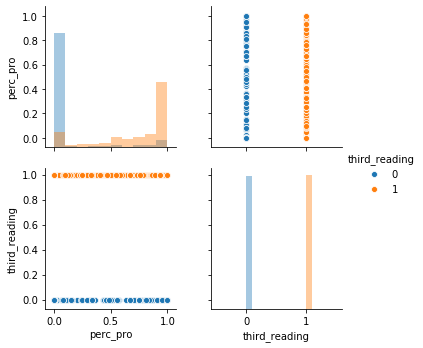

In [537]:
sns.pairplot(
    slip_features[['perc_pro', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

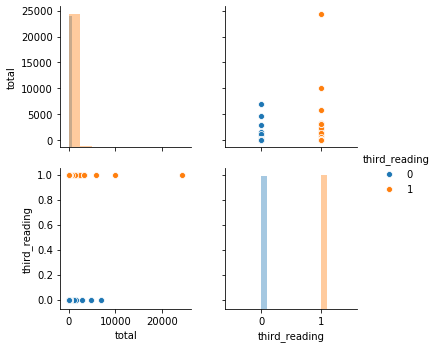

In [538]:
sns.pairplot(
    slip_features[['total', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

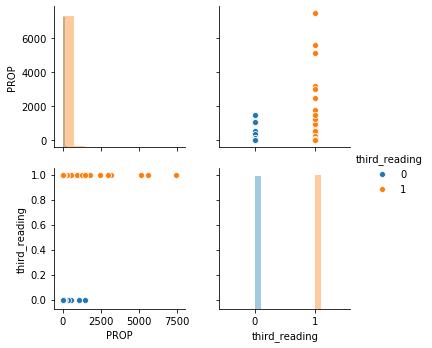

In [539]:
sns.pairplot(
    slip_features[['PROP', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

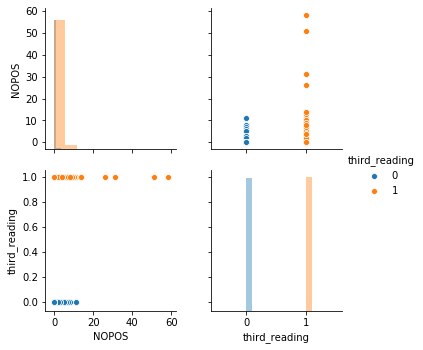

In [541]:
sns.pairplot(
    slip_features[['NOPOS', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Get Senator Info

## Scrape Info

In [4]:
def scrape_experience(vote_smart_id):
    url_bio = f'https://justfacts.votesmart.org/candidate/biography/{vote_smart_id}'
    res = requests.get(url_bio)
    sen_soup = BeautifulSoup(res.text)
    exp = scrape_collapse(sen_soup, 'collapseThree')
    comms = scrape_collapse(sen_soup, 'collapseFour')
    return { 'committees': comms, 'experience': exp }

In [5]:
def scrape_collapse(soup, id_):
    try:
        return [p.text for p in soup.find(id=id_).find_all('p')]
    except KeyboardInterrupt:
        raise
    except:
        return []

In [6]:
def scrape_funding(vote_smart_id):
    url_fund = f'https://justfacts.votesmart.org/candidate/campaign-finance/{vote_smart_id}'
    res_fund = requests.get(url_fund)
    soup_fund = BeautifulSoup(res_fund.text)
    summary = scrape_funding_section(soup_fund, 'nimspSummary')
    by_industry = scrape_funding_section(soup_fund, 'nimspIndustries')
    by_sector = scrape_funding_section(soup_fund, 'nimspSectors')
    
    return { 'indsutry': by_industry, 'sector': by_sector, 'summary': summary }

In [7]:
def scrape_funding_section(soup, id_):
    funding_cat = {}
    try:
        for tr in soup.find(id=id_).find('table').find_all('tr'):
            tds = tr.find_all('td')
            try:
                funding_cat[tds[0].text] = tds[1].text
            except KeyboardInterrupt:
                raise
            except:
                continue
    except KeyboardInterrupt:
        raise
    except:
        if id_ == 'nimspSummary':
            return scrape_funding_section(soup, 'crpSummary')
        # do nothing

    return funding_cat

In [8]:
query_get_vote_smart_id = """
    select p.people_id, p.votesmart_id
    from people p
    where role ='Sen'
"""

sen_vote_smart = pd.read_sql(query_get_vote_smart_id, con=engine)

In [9]:
sen_vote_smart.head()

,people_id,votesmart_id
0,949,33905
1,984,68145
2,1013,83646
3,1051,18385
4,1052,6303


In [10]:
results =[]

def scrape_all(people_id, votesmart_id):
    exp = scrape_experience(votesmart_id)
    funding = scrape_funding(votesmart_id)
    new_data = { 'people_id': people_id, ** exp, **funding }
    results.append(new_data)

In [11]:
sen_vote_smart.apply(lambda x: scrape_all(x.people_id, x.votesmart_id), axis=1)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
59    None
60    None
61    None
62    None
63    None
64    None
65    None
66    None
67    None
68    None
69    None
dtype: object

In [13]:
with open('./data/scrape_results.pickle', 'wb') as write_file:
    pickle.dump(results, write_file)

In [2]:
with open('./data/scrape_results.pickle', 'rb') as read_file:
    scraped_results = pickle.load(read_file)

## Persist Committee Data

In [8]:
def create_committee_df(scraped_results):
    rows = []
    for res in scraped_results:
        people_id = res['people_id']
        new_rows = [{ 'people_id': people_id, 'committee': comm } for comm in res['committees']]
        rows = rows + new_rows
    return pd.DataFrame(rows)
    

In [10]:
comms = create_committee_df(scraped_results)

In [ ]:
comms = comms.replace(to_replace='No committee memberships found.', value=np.nan)

In [ ]:
comms['role'] = comms.committee.map(lambda x: x.split(',')[0], na_action='ignore')

In [25]:
comms['committee'] = comms.committee.map(lambda x: x.split(',')[1], na_action='ignore')

In [32]:
comms.committee.value_counts().sort_index()
# looks like no typos

 Agriculture                                                   10
 Appropriations I                                              11
 Appropriations II                                              9
 Assignments                                                    3
 Commerce and Economic Development                             10
 Committee of the Whole                                        49
 Criminal Law                                                   6
 Criminal Law Subcommittee on Firearms                          1
 Criminal Law Subcommittee on Special Issues                    2
 Education                                                     14
 Education Subcommittee on Special Issues                       3
 Energy and Public Utilities                                   21
 Energy and Public Utilities Subcommittee on Special Issues     2
 Environment and Conservation                                   8
 Executive                                                     17
 Executive

In [33]:
comms.head()

,people_id,committee,role
0,949,Appropriations I,Member
1,949,Appropriations II,Member
2,949,Committee of the Whole,Member
3,949,Financial Institutions,Member
4,949,Higher Education,Member


In [37]:
committees = pd.DataFrame(comms.committee.unique().reshape(-1, 1), columns=['name']).dropna()

In [39]:
# replace committee value with id from 
comms['committee_id'] = comms.committee.map(lambda x: committees[committees.name == x].index[0], na_action='ignore')

In [43]:
comms = comms.dropna()

In [45]:
comms.committee_id = comms.committee_id.astype(int)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
comms.head()

,people_id,committee,role,committee_id
0,949,Appropriations I,Member,0
1,949,Appropriations II,Member,1
2,949,Committee of the Whole,Member,2
3,949,Financial Institutions,Member,3
4,949,Higher Education,Member,4


In [49]:
comms = comms.drop(columns=['committee'])

In [86]:
# csv, scp file to aws, copy from psql
comms.loc[1:, :].to_csv('./data/people_committee.csv')

,name
0,Appropriations I
1,Appropriations II
2,Committee of the Whole
3,Financial Institutions
4,Higher Education


In [88]:
# really small table so use slow api
committees.to_sql('committee', con=aws_engine)

## Experience and Funding

In [102]:
def create_experience_df(scraped_results):
    rows = []
    for res in scraped_results:
        people_id = res['people_id']
        new_rows = [{ 'people_id': people_id, 'experience': exp } for exp in res['experience'] if 'Illinois State Senate' in exp]
        rows = rows + new_rows
    return pd.DataFrame(rows)
    

In [103]:
exp_exploration = create_experience_df(scraped_results)

In [114]:
# If it says Senator or Representative -> add up the years
# if it says Leader/WHIP and Illinois State Senate/House
sen_exp = exp_exploration[exp_exploration.experience.str.contains('Senator,')]

In [122]:
sen_exp['years_senate_raw'] = sen_exp.experience.map(lambda x: x.split(', ')[-1])

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
sen_exp['years_senate'] = sen_exp.years_senate_raw.map(lambda x: 2017 - int(x.split('-')[0]))

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [129]:
sen_exp.years_senate = sen_exp.years_senate.where(sen_exp.years_senate >=0, 0)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [130]:
sen_exp.head()

,people_id,experience,years_senate,years_senate_raw
1,949,"Senator, Illinois State Senate, District 51, ...",5,2012-present
4,984,"Senator, Illinois State Senate, District 47, ...",0,2017-present
8,1013,"Senator, Illinois State Senate, District 21, ...",5,2012-2019
11,1051,"Senator, Illinois State Senate, District 1, 1...",18,1999-present
13,1052,"Senator, Illinois State Senate, District 44, ...",15,2002-present


In [140]:
def create_funding_df(scraped_results):
    rows = []
    for res in scraped_results:
        people_id = res['people_id']
        total = res['summary']['Total'] if 'Total' in res['summary'] else np.nan
        new_rows = { 'people_id': people_id, 'total_funding': total }
        rows.append(new_rows)
    return pd.DataFrame(rows)
    

In [142]:
funding_df = create_funding_df(scraped_results)

In [145]:
sen_bio = sen_exp.merge(funding_df, on='people_id', how='outer')

In [148]:
sen_bio = sen_bio.drop(columns=['experience', 'years_senate_raw'])

In [150]:
sen_bio.total_funding = sen_bio.total_funding.str.replace('$', '')
sen_bio.total_funding = sen_bio.total_funding.str.replace(',', '')
sen_bio.total_funding = sen_bio.total_funding.astype(float)

In [151]:
sen_bio.head()

,people_id,years_senate,total_funding
0,949,5.0,275977.39
1,984,0.0,206051.47
2,1013,5.0,1300803.62
3,1051,18.0,1419612.36
4,1052,15.0,3478061.43


In [153]:
sen_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 3 columns):
people_id        70 non-null int64
years_senate     66 non-null float64
total_funding    61 non-null float64
dtypes: float64(2), int64(1)
memory usage: 2.2 KB


In [154]:
# really small table so use slow api
sen_bio.to_sql('people_detail', con=aws_engine)

# Author is a Committee Chair

In [163]:
query_auth_comm = """
select b.bill_id, b.third_reading, case when max(pc.people_id) > 0 then 1 else 0 end as is_chair from sen_bill b
join author a on a.bill_id = b.bill_id
left join people_committee pc on pc.people_id = a.people_id and pc.role ~* 'chair'
group by b.bill_id, b.third_reading;
"""

auth_comm = pd.read_sql(query_auth_comm, con=aws_engine)

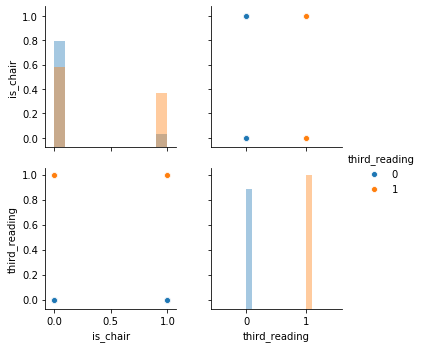

In [166]:
sns.pairplot(
    auth_comm[['is_chair', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Experience of Author

In [155]:
query_auth_exp = """
select * from sen_bill b
join author a on a.bill_id = b.bill_id
join people_detail p on p.people_id = a.people_id;
"""

auth_exp = pd.read_sql(query_auth_exp, con=aws_engine)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


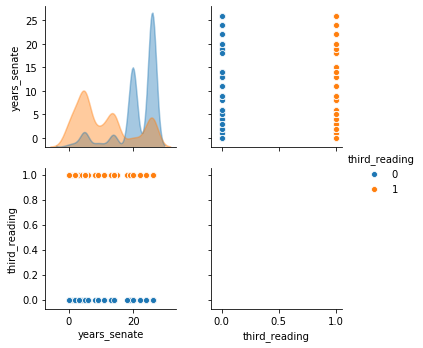

In [158]:
sns.pairplot(
    auth_exp[['years_senate', 'third_reading']],
    hue='third_reading',
    diag_kind='kde',
    diag_kws={ 'alpha': 0.4 }
)

# Funding of Author

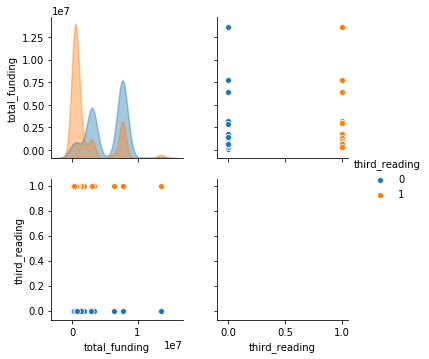

In [159]:
sns.pairplot(
    auth_exp[['total_funding', 'third_reading']],
    hue='third_reading',
    diag_kind='kde',
    diag_kws={ 'alpha': 0.4 }
)

# Has a Committee Chair Sponsor

In [167]:
sponsor_chair = """
select b.bill_id, b.third_reading, case when max(pc.people_id) > 0 then 1 else 0 end as has_chair from sen_bill b
left join sponsor_at_second a on a.bill_id = b.bill_id
left join people_committee pc on pc.people_id = a.people_id and pc.role ~* 'chair'
group by b.bill_id, b.third_reading;
"""

spons_chair = pd.read_sql(sponsor_chair, con=aws_engine)

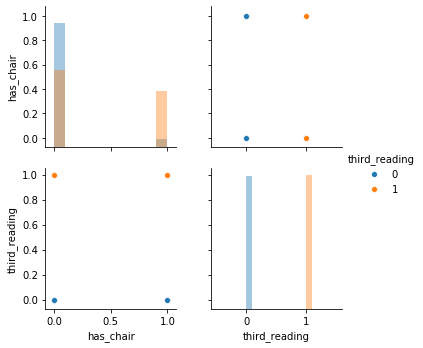

In [169]:
sns.pairplot(
    spons_chair[['has_chair', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Aggregate Experience of Co-Sponsors

In [177]:
query_spons_exp = """
select b.bill_id, b.third_reading, coalesce(sum(pd.years_senate), 0) as agg_exp from sen_bill b
left join sponsor_at_second a on a.bill_id = b.bill_id
left join people_detail pd on pd.people_id = a.people_id
group by b.bill_id, b.third_reading;
"""

spons_exp = pd.read_sql(query_spons_exp, con=aws_engine)

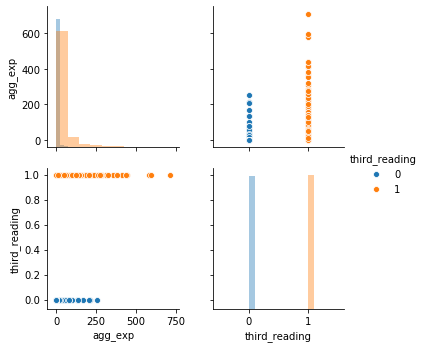

In [174]:
sns.pairplot(
    spons_exp[['agg_exp', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Avg Experience of the Co-Sponsor

In [187]:
query_spons_exp_avg = """
select 
	b.bill_id,
	b.third_reading, 
	coalesce(sum(pd.years_senate), 0) / case when count(pd.years_senate) > 0 then count(pd.years_senate) else 1 end as avg_exp
from sen_bill b
left join sponsor_at_second a on a.bill_id = b.bill_id
left join people_detail pd on pd.people_id = a.people_id
group by b.bill_id, b.third_reading;
"""

spons_exp_avg = pd.read_sql(query_spons_exp_avg, con=aws_engine)

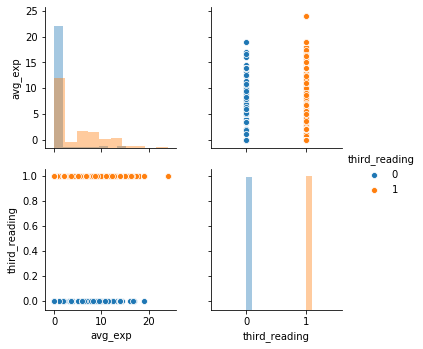

In [189]:
sns.pairplot(
    spons_exp_avg[['avg_exp', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Aggregate Funding of Co-Sponsors

In [191]:
query_spons_fund = """
select b.bill_id, b.third_reading, coalesce(sum(pd.total_funding), 0) as agg_funding from sen_bill b
left join sponsor_at_second a on a.bill_id = b.bill_id
left join people_detail pd on pd.people_id = a.people_id
group by b.bill_id, b.third_reading;
"""

spons_fund = pd.read_sql(query_spons_fund, con=aws_engine)

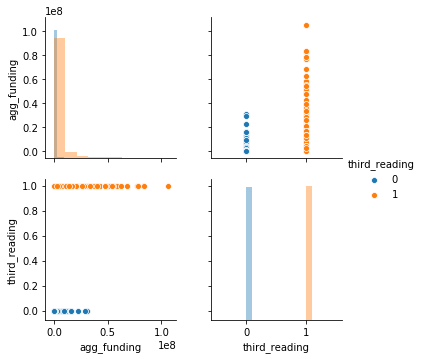

In [192]:
sns.pairplot(
    spons_fund[['agg_funding', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Avg Sponsor Funding

In [194]:
query_spons_fund_avg = """
select 
	b.bill_id,
	b.third_reading, 
	coalesce(sum(pd.years_senate), 0) / case when count(pd.total_funding) > 0 then count(pd.total_funding) else 1 end as avg_fund
from sen_bill b
left join sponsor_at_second a on a.bill_id = b.bill_id
left join people_detail pd on pd.people_id = a.people_id
group by b.bill_id, b.third_reading;
"""

spons_fund_avg = pd.read_sql(query_spons_fund_avg, con=aws_engine)

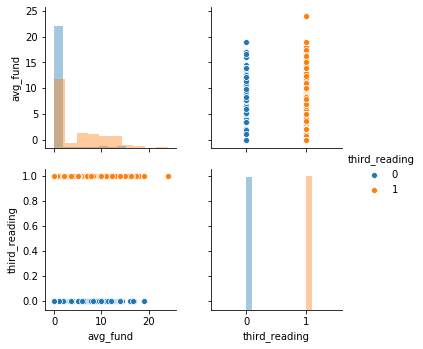

In [195]:
sns.pairplot(
    spons_fund_avg[['avg_fund', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# What party author is in

In [199]:
query_auth_party = """
select b.bill_id, b.third_reading, p.party_id from sen_bill b
join author a on a.bill_id = b.bill_id
join people p on a.people_id = p.people_id
"""

auth_party = pd.read_sql(query_auth_party, con=aws_engine)

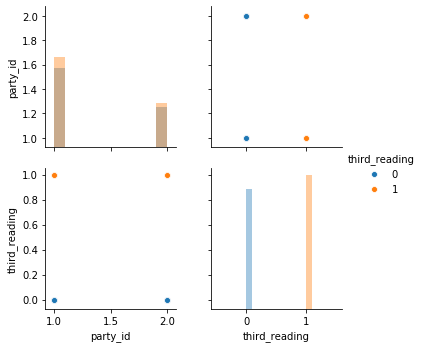

In [201]:
sns.pairplot(
    auth_party[['party_id', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# Has Bipartisan Sponsors

In [202]:
query_bipartisan = """
select
	b.bill_id,
	b.third_reading,
	case when max(pd.people_id) > 0 and max(pr.people_id) > 0 then 1 else 0 end as is_bipart
from sen_bill b
left join sponsor_at_second sd on sd.bill_id = b.bill_id
left join people pd on pd.people_id = sd.people_id and pd.party = 'D'
left join sponsor_at_second sr on sr.bill_id = b.bill_id
left join people pr on pr.people_id = sr.people_id and pr.party = 'R'
group by b.bill_id, b.third_reading;
"""

bipart = pd.read_sql(query_bipartisan, con=aws_engine)

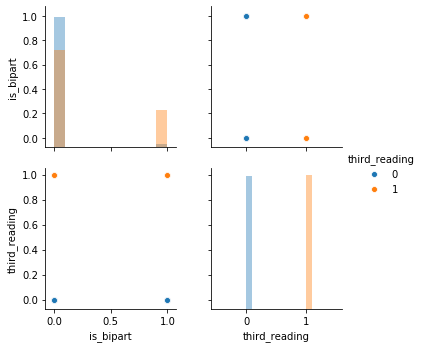

In [203]:
sns.pairplot(
    bipart[['is_bipart', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

# First word

In [32]:
query_text = """
select b.bill_id, b.third_reading, b.description, b.status_desc
from sen_bill b
"""

bill_text = pd.read_sql(query_text, con=aws_engine)

In [33]:
bill_text['first_word'] = bill_text.description.map(lambda x: x.split(' ')[0])

In [38]:
bill_text.first_word.value_counts()

Amends          1641
Creates           72
Appropriates      21
Repeals            6
Authorizes         3
Makes              2
Provides           2
Requires           1
Name: first_word, dtype: int64

In [34]:
bill_text['amends_first_word'] = bill_text.first_word.map(lambda x: 1 if x == 'Amends' else 0)

In [35]:
bill_text['app_first_word'] = bill_text.first_word.map(lambda x: 1 if x == 'Appropriates' else 0)

In [39]:
bill_text['create_first_word'] = bill_text.first_word.map(lambda x: 1 if x == 'Creates' else 0)

In [36]:
bill_text.app_first_word.value_counts()

0    1727
1      21
Name: app_first_word, dtype: int64

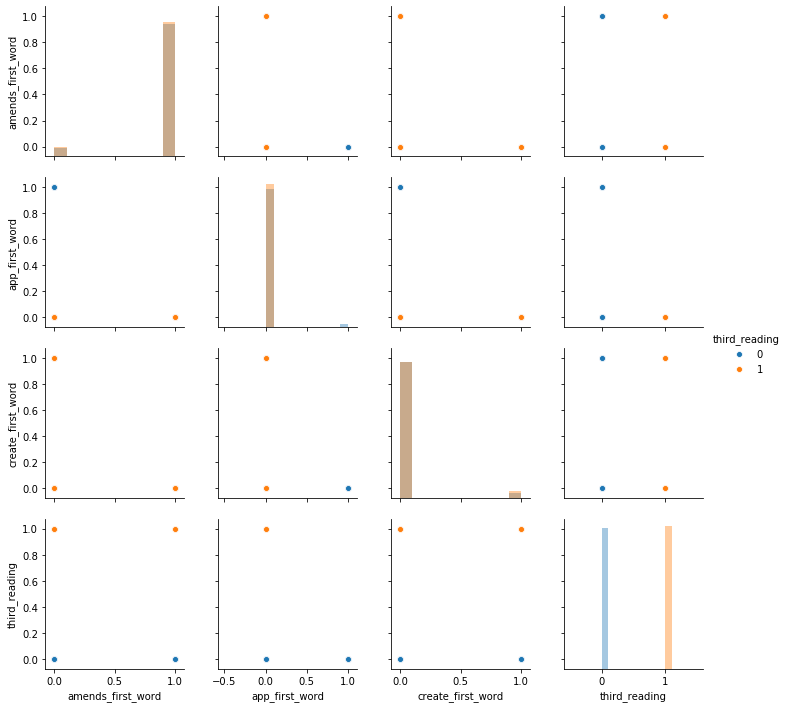

In [40]:
sns.pairplot(
    bill_text[['amends_first_word', 'app_first_word', 'create_first_word', 'third_reading']],
    hue='third_reading',
    diag_kind='hist',
    diag_kws={ 'alpha': 0.4 }
)

In [25]:
bill_text[bill_text.first_word == 'Appropriates']

,bill_id,third_reading,description,status_desc,first_word,amends_first_word,app_first_word
84,918020,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
212,918018,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
510,917338,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
722,917792,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
728,917884,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
769,917256,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
771,917712,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
843,917207,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
882,917601,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0
995,917581,0,Appropriates $2 from the General Revenue Fund ...,Failed,Appropriates,1,0


In [ ]:
# first word doesn't matter
# except that if it's "Appropriates" it never passed -> need to understand this better

In [45]:
val = [12, 23, 1, 13, 13, 13]
ids = [1, 2, 3, 4, 4, 4]

In [50]:
(sum(val) / 6) * 4

28.0

In [43]:
sum([12, 23, 1, 13]) / 4

12.25